In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

In [2]:
pd.set_option('max_columns', 50)

In [3]:
df = gpd.read_file(
    'housing_sites/xn--Bay_Area_Housing_Opportunity_Sites_Inventory__20072023_-it38a.shp'
)

In [4]:
sf_sites = df.query('jurisdict == "San Francisco" and rhnacyc == "RHNA5"').copy()
sf_sites['allowden'] = sf_sites['allowden'].astype(float)
sf_sites['relcapcty'] = sf_sites['relcapcty'].astype(float)

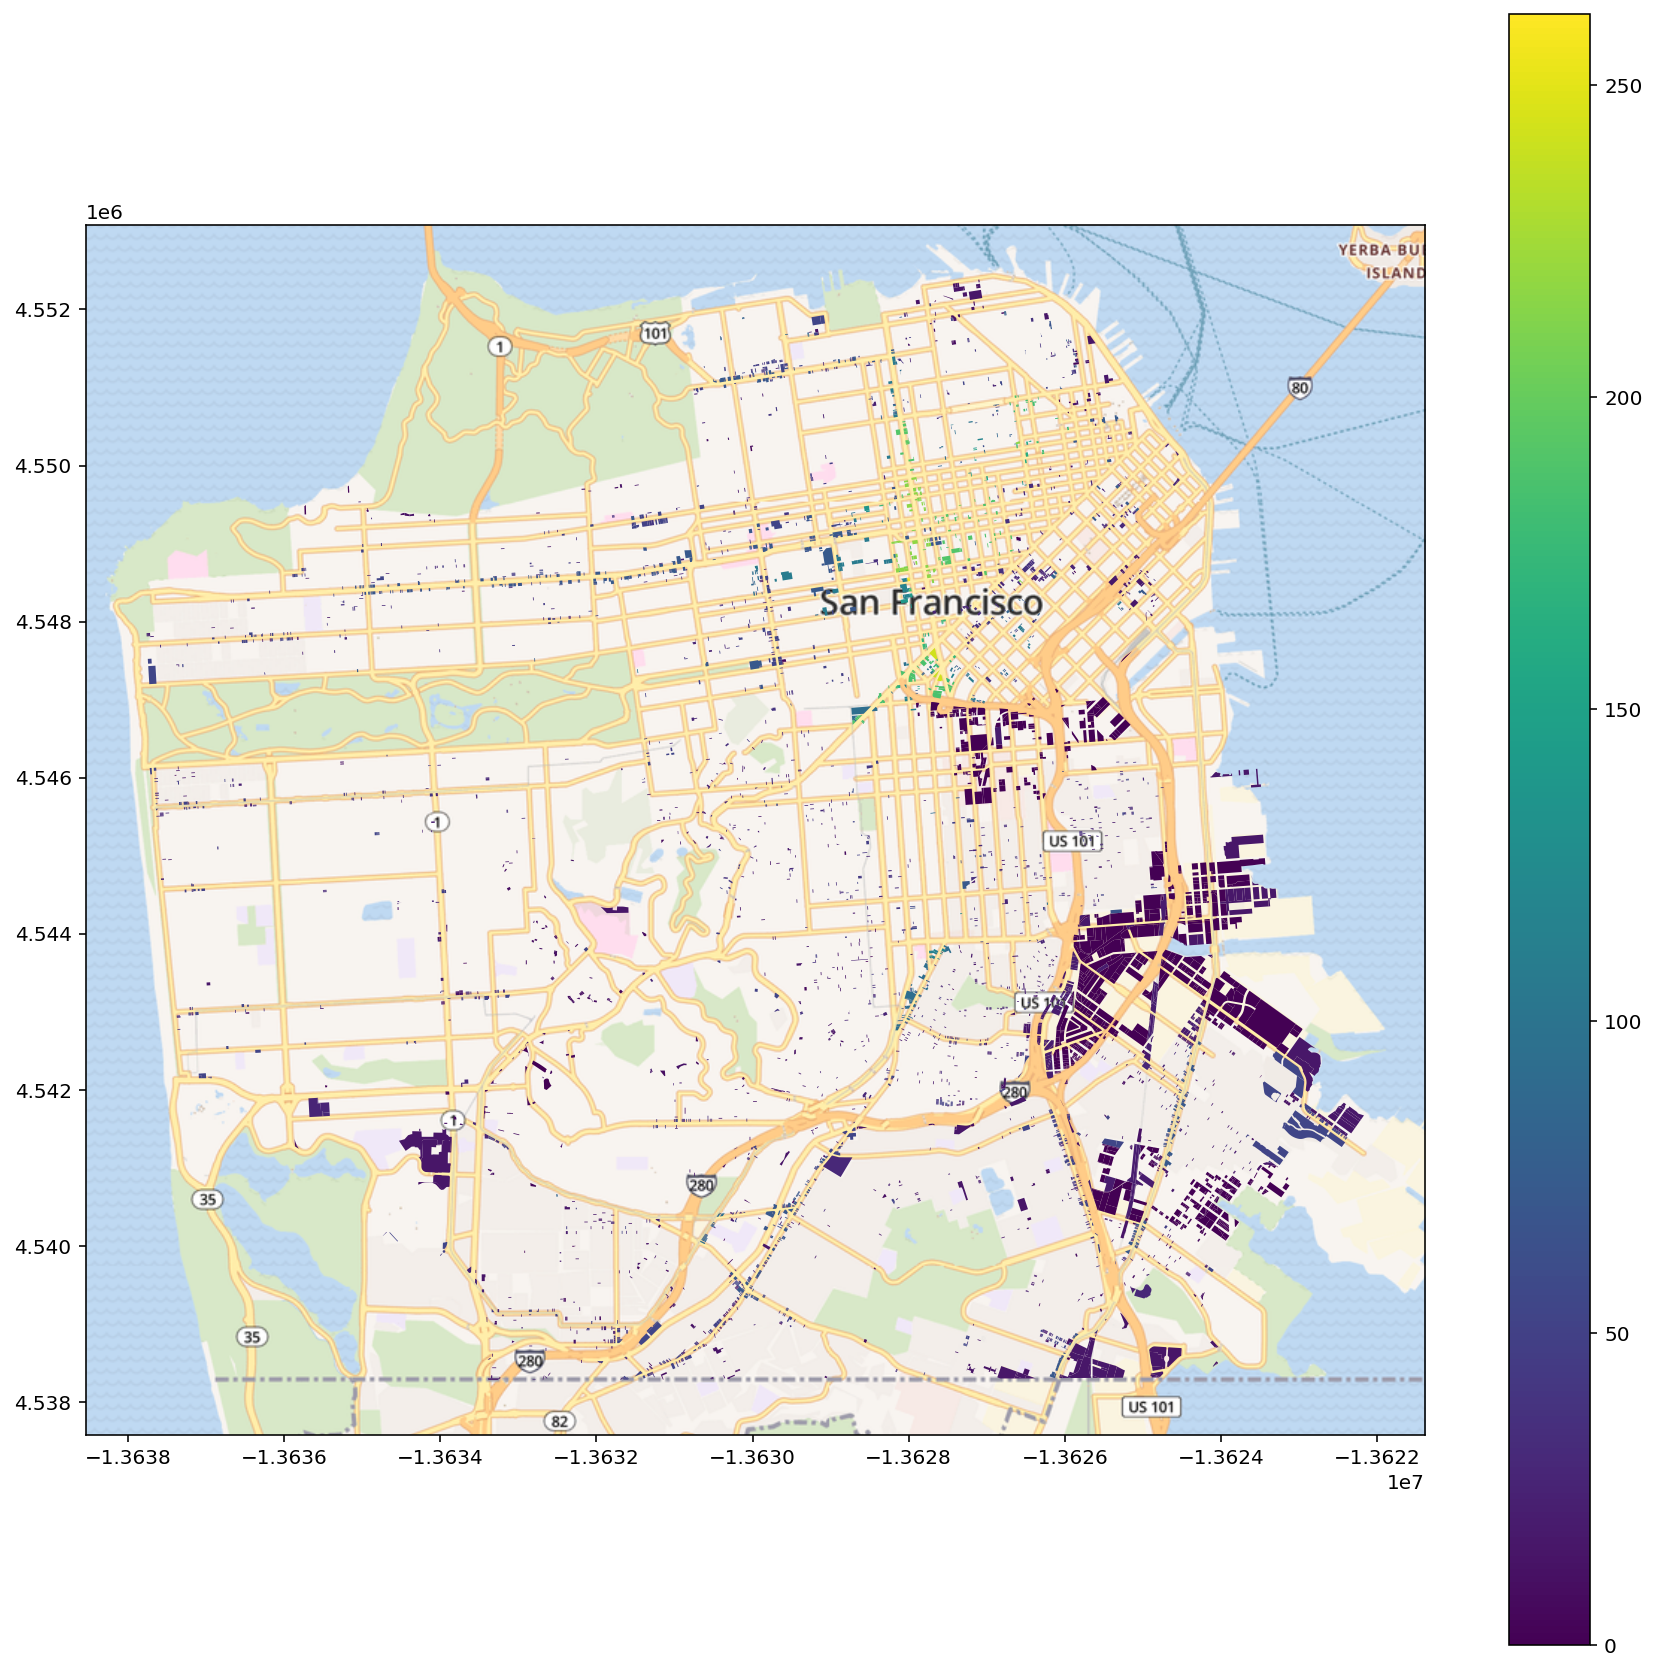

In [7]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

to_plot = sf_sites.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(15, 15))

to_plot.plot(ax=ax, column='allowden', legend=True)

ctx.add_basemap(
    ax, 
    source='https://tiles.stadiamaps.com/tiles/osm_bright/{z}/{x}/{y}{r}.png?api_key=c50d11b9-261a-4916-b968-fe8854621c78'
)

In [8]:
df.columns

Index(['objectid', 'rhnacyc', 'rhnayrs', 'county', 'jurisdict', 'apn',
       'locapn', 'genplan', 'zoning', 'gacres', 'locacres', 'currunits',
       'allowden', 'allowlow', 'allowhigh', 'relcapcty', 'desafford', 'aff_vl',
       'aff_l', 'aff_m', 'aff_am', 'num_vl', 'num_l', 'num_m', 'num_am',
       'infcapcty', 'siteconst', 'sitetype', 'pdaparcel', 'bundled',
       'existuse', 'localnote', 'Shape__Are', 'Shape__Len', 'geometry'],
      dtype='object')

In [5]:
sf_building_permits = pd.read_csv('https://data.sfgov.org/api/views/p4e4-a5a7/rows.csv?accessType=DOWNLOAD')

/Users/sidharthkapur/Library/Caches/pypoetry/virtualenvs/housing-elements-H302xxA9-py3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (22,32,35) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [29]:
sf_building_permits['apn'] = sf_building_permits['Block'] + '/' + sf_building_permits['Lot']

In [30]:
sf_building_permits['Filed Date'] = pd.to_datetime(sf_building_permits['Filed Date'])

In [161]:
[c for c in sf_building_permits.columns if 'Date' in c]

['Permit Creation Date',
 'Current Status Date',
 'Filed Date',
 'Issued Date',
 'Completed Date',
 'First Construction Document Date',
 'Permit Expiration Date']

In [162]:
sf_building_permits['Current Status Date'] = pd.to_datetime(sf_building_permits['Current Status Date'])
sf_building_permits['Issued Date'] = pd.to_datetime(sf_building_permits['Issued Date'])
sf_building_permits['Completed Date'] = pd.to_datetime(sf_building_permits['Completed Date'])
sf_building_permits['First Construction Document Date'] = pd.to_datetime(sf_building_permits['First Construction Document Date'])
sf_building_permits['Permit Expiration Date'] = pd.to_datetime(sf_building_permits['Permit Expiration Date'])

In [163]:
sf_building_permits[[
    'Permit Type', 'Permit Type Definition'
]].drop_duplicates().sort_values('Permit Type')

,Permit Type,Permit Type Definition
1402,1,new construction
284,2,new construction wood frame
12,3,additions alterations or repairs
0,4,sign - erect
3136,5,grade or quarry or fill or excavate
1289,6,demolitions
17,7,wall or painted sign
2,8,otc alterations permit


In [164]:
sf_building_permits.loc[lambda x: x['Permit Type'].isin([1, 2])]['Proposed Use'].value_counts()

apartments              774
1 family dwelling       521
2 family dwelling       347
office                   73
prkng garage/private     29
recreation bldg          17
tourist hotel/motel      15
storage shed             14
warehouse,no frnitur     12
school                   12
food/beverage hndlng     11
retail sales             10
manufacturing             7
prkng garage/public       7
workshop commercial       7
filling/service stn       6
misc group residns.       6
residential hotel         5
auto repairs              5
muni driver restroom      5
fence/retaining wall      5
health studios & gym      3
church                    3
clinics-medic/dental      3
warehouse, furniture      3
public assmbly other      3
radio & tv stations       2
sfpd or sffd station      2
car wash                  2
nursing home non amb      2
parking lot               2
power plant               2
consulate                 1
ambulance service         1
greenhouse                1
printing plant      

In [165]:
sf_new_construction_all = sf_building_permits[
    sf_building_permits['Permit Type'].isin([1, 2])
    & sf_building_permits['Proposed Use'].isin(['apartments', '1 family dwelling', '2 family dwelling', 'residential hotel', 'misc group residns.'])
]

In [181]:
sf_new_construction_post_2015 = sf_building_permits[
    sf_building_permits['Permit Type'].isin([1, 2])
    & (sf_building_permits['Issued Date'] >= '2015-01-01')
    & sf_building_permits['Proposed Use'].isin(['apartments', '1 family dwelling', '2 family dwelling', 'residential hotel', 'misc group residns.'])
]

In [182]:
pd.set_option('max_columns', 100)

## Make sure the `relcapcty` column is what we want:

In [183]:
test_df = pd.DataFrame({
    'maybe_density': sf_sites['allowden'] * sf_sites['locacres'],
    'capacity': sf_sites['relcapcty'].astype(float)
}).dropna()
test_df['maybe_density_int'] = test_df['maybe_density'].round(1)
test_df['capacity_int'] = test_df['capacity'].round(1)

In [184]:
(test_df['maybe_density_int'] == test_df['capacity_int']).mean()

1.0

## Now let's do some stats:

In [185]:
sf_sites['apn'].isin(sf_new_construction_all['apn']).mean()

0.06187073725235466

In [186]:
sf_sites['apn'].isin(sf_new_construction_post_2015['apn']).mean()

0.033290029230269566

In [187]:
sf_new_construction_all['apn'].isin(sf_sites['apn']).mean()

0.31518451300665457

In [188]:
sf_new_construction_post_2015['apn'].isin(sf_sites['apn']).mean()

0.3220338983050847

## Number of units in HE:

In [189]:
sf_sites['relcapcty'].sum()

47209.0

## Overall number of units completed:

In [190]:
sf_new_construction_all[
    sf_new_construction_all['Filed Date'].notnull()
]['Proposed Units'].sum()

51016.0

In [191]:
sf_new_construction_all[
    sf_new_construction_all['Issued Date'].notnull()
]['Proposed Units'].sum()

32460.0

In [192]:
sf_new_construction_all[
    sf_new_construction_all['First Construction Document Date'].notnull()
]['Proposed Units'].sum()

25780.0

In [193]:
sf_new_construction_all[
    sf_new_construction_all['Completed Date'].notnull()
]['Proposed Units'].sum()

13432.0

In [194]:
sf_new_construction_post_2015[
    sf_new_construction_post_2015['Filed Date'].notnull()
]['Proposed Units'].sum()

28137.0

In [195]:
sf_new_construction_post_2015[
    sf_new_construction_post_2015['Issued Date'].notnull()
]['Proposed Units'].sum()

28137.0

In [196]:
sf_new_construction_post_2015[
    sf_new_construction_post_2015['First Construction Document Date'].notnull()
]['Proposed Units'].sum()

21691.0

In [197]:
sf_new_construction_post_2015[
    sf_new_construction_post_2015['Completed Date'].notnull()
]['Proposed Units'].sum()

9445.0

In [198]:
sf_new_construction_all[
    sf_new_construction_all['Completed Date'] >= '2015-01-01'
]['Proposed Units'].sum()

13427.0

In [199]:
13427 / 28800

0.46621527777777777

In [200]:
13427 / 5

2685.4

In [201]:
sf_new_construction_all[
    (sf_new_construction_all['Completed Date'] >= '2015-01-01')
    & (sf_new_construction_all['Issued Date'] < '2015-01-01')
]

,Permit Number,Permit Type,Permit Type Definition,Permit Creation Date,Block,Lot,Street Number,Street Number Suffix,Street Name,Street Suffix,Unit,Unit Suffix,Description,Current Status,Current Status Date,Filed Date,Issued Date,Completed Date,First Construction Document Date,Structural Notification,Number of Existing Stories,Number of Proposed Stories,Voluntary Soft-Story Retrofit,Fire Only Permit,Permit Expiration Date,Estimated Cost,Revised Cost,Existing Use,Existing Units,Proposed Use,Proposed Units,Plansets,TIDF Compliance,Existing Construction Type,Existing Construction Type Description,Proposed Construction Type,Proposed Construction Type Description,Site Permit,Supervisor District,Neighborhoods - Analysis Boundaries,Zipcode,Location,Record ID,SF Find Neighborhoods,Current Police Districts,Current Supervisor Districts,Analysis Neighborhoods,DELETE - Zip Codes,DELETE - Fire Prevention Districts,DELETE - Supervisor Districts,DELETE - Current Police Districts,DELETE - Supervisorial_Districts_Waterline_data_from_7pkg_wer3,apn
284,201301047264,2,new construction wood frame,01/04/2013,6415,022,1310,V,Geneva,Av,NaN,NaN,erect 3-story type v single family dwelling re...,complete,2015-04-01,2013-01-04,2013-06-14,2015-04-01,2013-08-16,NaN,NaN,3.0,NaN,NaN,2016-05-29,185000.0,528451.0,NaN,NaN,1 family dwelling,1.0,2.0,NaN,NaN,NaN,5.0,wood frame (5),Y,11.0,Excelsior,94112.0,"(37.71310153680584, -122.43440876443277)",1292403202611,58.0,9.0,1.0,7.0,28861.0,9.0,6.0,4.0,8.0,6415/022
1402,201301168124,1,new construction,01/16/2013,3616,084,2558,NaN,Mission,St,NaN,NaN,"to erect 8 stories, 1 basement, 114 units resi...",complete,2015-01-12,2013-01-16,2013-06-07,2015-01-12,2013-08-14,NaN,NaN,8.0,NaN,NaN,2019-05-07,35000000.0,35000000.0,NaN,NaN,apartments,114.0,2.0,NaN,NaN,NaN,1.0,constr type 1,Y,9.0,Mission,94110.0,"(37.755955414098764, -122.41936731951357)",1306830491542,53.0,3.0,2.0,20.0,28859.0,2.0,7.0,7.0,7.0,3616/084
2690,201301319232,1,new construction,01/31/2013,3509,043,104,NaN,09th,St,NaN,NaN,"to erect 160 units, 11 stories with basement m...",complete,2016-09-13,2013-01-31,2013-08-29,2016-09-13,2013-11-04,NaN,NaN,11.0,NaN,NaN,2019-07-29,20000000.0,29011002.0,NaN,NaN,apartments,160.0,2.0,NaN,NaN,NaN,1.0,constr type 1,Y,6.0,South of Market,94103.0,"(37.77587440253431, -122.41474608156896)",1294896156329,32.0,1.0,10.0,34.0,28853.0,8.0,9.0,2.0,3.0,3509/043
2723,201301319232,1,new construction,01/31/2013,3509,043,1321,NaN,Mission,St,NaN,NaN,"to erect 160 units, 11 stories with basement m...",complete,2016-09-13,2013-01-31,2013-08-29,2016-09-13,2013-11-04,NaN,NaN,11.0,NaN,NaN,2019-07-29,20000000.0,29011002.0,NaN,NaN,apartments,160.0,2.0,NaN,NaN,NaN,1.0,constr type 1,Y,6.0,South of Market,94103.0,"(37.77587440253431, -122.41474608156896)",1316019492719,32.0,1.0,10.0,34.0,28853.0,8.0,9.0,2.0,3.0,3509/043
4138,201302150317,2,new construction wood frame,02/15/2013,0776,035,1470,NaN,Mcallister,St,NaN,NaN,erect 4-story three dwelling units type v new ...,complete,2016-10-05,2013-02-15,2013-12-19,2016-10-05,2015-05-21,NaN,NaN,4.0,NaN,NaN,2016-12-03,900000.0,1356000.0,NaN,NaN,apartments,3.0,2.0,NaN,NaN,NaN,5.0,wood frame (5),Y,5.0,Western Addition,94115.0,"(37.77827589264173, -122.43639816996871)",1325539495348,97.0,4.0,11.0,39.0,29490.0,15.0,11.0,8.0,10.0,0776/035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50430,201406057554,2,new construction wood frame,06/05/2014,0629,037,2468,NaN,Sacramento,St,NaN,NaN,"(townhouse# 2) to erect 3 stories, no basement...",complete,2016-09-26,2014-06-05,2014-12-02,2016-09-26,2015-01-06,NaN,NaN,4.0,NaN,NaN,2017-11-16,1500000.0,1500000.0,NaN,NaN,apartments,3.0,2.0,NaN,NaN,NaN,5.0,wood frame (5),Y,2.0,Pacific Heights,94115.0,"(37.79026895086345, -122.43276392413539)",1363875501985,102.0,4.0,6.0,30.0,29490.0,13.0,1.0,6.0,11.0,0629/037
50431,20140

# By capacity

In [134]:
sf_sites.columns

Index(['objectid', 'rhnacyc', 'rhnayrs', 'county', 'jurisdict', 'apn',
       'locapn', 'genplan', 'zoning', 'gacres', 'locacres', 'currunits',
       'allowden', 'allowlow', 'allowhigh', 'relcapcty', 'desafford', 'aff_vl',
       'aff_l', 'aff_m', 'aff_am', 'num_vl', 'num_l', 'num_m', 'num_am',
       'infcapcty', 'siteconst', 'sitetype', 'pdaparcel', 'bundled',
       'existuse', 'localnote', 'Shape__Are', 'Shape__Len', 'geometry'],
      dtype='object')

In [135]:
sf_sites.shape

(6158, 35)

In [136]:
sf_sites['relcapcty'].value_counts()[:10]

1.0     1103
2.0      959
0.0      904
3.0      687
4.0      463
5.0      291
6.0      227
7.0      194
8.0      139
9.0      117
10.0     102
Name: relcapcty, dtype: int64

In [137]:
(sf_sites['relcapcty'] > 10).sum()

972

In [138]:
for n in range(1, 11):
    print(n)
    print(
        sf_sites[
            sf_sites['relcapcty'] == n
        ]['apn'].isin(sf_new_construction_all['apn']).mean()
    )
    print()

1
0.09247506799637353

2
0.054223149113660066

3
0.036390101892285295

4
0.06695464362850972

5
0.061855670103092786

6
0.039647577092511016

7
0.07731958762886598

8
0.07194244604316546

9
0.09401709401709402

10
0.029411764705882353



In [139]:
sf_sites[
    sf_sites['relcapcty'] > 10
]['apn'].isin(sf_new_construction_all['apn']).mean()

0.09670781893004116

# Merging the datasets

In [140]:
merged_df = sf_sites.merge(
    sf_new_construction_all,
    on='apn',
    how='left',
    indicator=True
)

In [141]:
merged_df['Lot Size Sq Ft'] = merged_df['locacres'] * 43560.

In [142]:
increase_df = merged_df[
    merged_df['Proposed Units'] > merged_df['relcapcty']
]

In [143]:
pd.set_option('max_rows', 100)

In [144]:
increase_df[
    increase_df['relcapcty'] == 0
]

,objectid,rhnacyc,rhnayrs,county,jurisdict,apn,locapn,genplan,zoning,gacres,locacres,currunits,allowden,allowlow,allowhigh,relcapcty,desafford,aff_vl,aff_l,aff_m,aff_am,num_vl,num_l,num_m,num_am,infcapcty,siteconst,sitetype,pdaparcel,bundled,existuse,localnote,Shape__Are,Shape__Len,geometry,Permit Number,Permit Type,Permit Type Definition,Permit Creation Date,Block,Lot,Street Number,Street Number Suffix,Street Name,Street Suffix,Unit,Unit Suffix,Description,Current Status,Current Status Date,Filed Date,Issued Date,Completed Date,First Construction Document Date,Structural Notification,Number of Existing Stories,Number of Proposed Stories,Voluntary Soft-Story Retrofit,Fire Only Permit,Permit Expiration Date,Estimated Cost,Revised Cost,Existing Use,Existing Units,Proposed Use,Proposed Units,Plansets,TIDF Compliance,Existing Construction Type,Existing Construction Type Description,Proposed Construction Type,Proposed Construction Type Description,Site Permit,Supervisor District,Neighborhoods - Analysis Boundaries,Zipcode,Location,Record ID,SF Find Neighborhoods,Current Police Districts,Current Supervisor Districts,Analysis Neighborhoods,DELETE - Zip Codes,DELETE - Fire Prevention Districts,DELETE - Supervisor Districts,DELETE - Current Police Districts,DELETE - Supervisorial_Districts_Waterline_data_from_7pkg_wer3,_merge,Lot Size Sq Ft
15,66781,RHNA5,2015-2023,6075,San Francisco,0024/020,0024/020,Northeast,C-2,0.036,0.036468,0,0.0,0,0,0.0,None,None,None,None,None,0,0,0,0,None,None,Underutilized,Y,None,Commercial,None,1.510125e-08,0.000574,"POLYGON ((-122.41924 37.80640, -122.41940 37.8...",201605177611,2.0,new construction wood frame,05/17/2016,0024,020,1327.0,NaN,Columbus,Av,NaN,NaN,"to construct 4 stories, no basement, single re...",issued,06/19/2019,2016-05-17,06/19/2019,NaN,NaN,NaN,NaN,4.0,NaN,NaN,06/03/2022,1100000.00,1100000.0,NaN,NaN,1 family dwelling,1.0,2.0,NaN,NaN,NaN,5.0,wood frame (5),NaN,2.0,Russian Hill,94109.0,"(37.80633880743539, -122.41931845372095)",1.423461e+11,99.0,6.0,6.0,32.0,28858.0,5.0,1.0,1.0,11.0,both,1588.550996
16,66781,RHNA5,2015-2023,6075,San Francisco,0024/020,0024/020,Northeast,C-2,0.036,0.036468,0,0.0,0,0,0.0,None,None,None,None,None,0,0,0,0,None,None,Underutilized,Y,None,Commercial,None,1.510125e-08,0.000574,"POLYGON ((-122.41924 37.80640, -122.41940 37.8...",201605177611,2.0,new construction wood frame,05/17/2016,0024,020,1327.0,A,Columbus,Av,NaN,NaN,"to construct 4 stories, no basement, single re...",issued,06/19/2019,2016-05-17,06/19/2019,NaN,NaN,NaN,NaN,4.0,NaN,NaN,06/03/2022,1100000.00,1100000.0,NaN,NaN,1 family dwelling,1.0,2.0,NaN,NaN,NaN,5.0,wood frame (5),NaN,2.0,Russian Hill,94109.0,"(37.80633880743539, -122.41931845372095)",1.556848e+12,99.0,6.0,6.0,32.0,28858.0,5.0,1.0,1.0,11.0,both,1588.550996
766,70115,RHNA5,2015-2023,6075,San Francisco,0106/002,0106/002,Northeast,C-2,0.061,0.061228,0,0.0,0,0,0.0,None,None,None,None,None,0,0,0,0,None,None,Vacant,Y,None,Vacant,None,2.535262e-08,0.000638,"POLYGON ((-122.40297 37.80149, -122.40304 37.8...",202010297708,1.0,new construction,10/29/2020,0106,002,1235.0,V,Sansome,St,NaN,NaN,"to erect a new 10 story,no basement,type 1-a, ...",filed,10/29/2020,2020-10-29,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,5000000.00,NaN,NaN,NaN,apartments,9.0,2.0,NaN,NaN,NaN,1.0,constr type 1,Y,3.0,North Beach,94133.0,"(37.80156039357431, -122.40304902015936)",1.602663e+11,18.0,6.0,3.0,23.0,308.0,3.0,10.0,1.0,2.0,both,2667.093866
1736,71104,RHNA5,2015-2023,6075,San Francisco,3552/012,3552/012,Mission,PDR-1-G,0.666,0.666168,0,0.0,0,0,0.0,None,None,None,None,None,0,0,0,0,None,None,Underutilized,Y,None,Commercial,None,2.757029e-07,0.002344,"POLYGON ((-122.41635 37.76569, -122.41551 37.7...",201707051030,1.0,new construction,07/05/2017,3552,012,1990.0,NaN,Folsom,St,NaN,NaN,"to erect 8 stories, type 1a,1b,vb 143 resident...",issued,08/31/2018,2017-07-05,08/31/2018,NaN,03/15/2019,NaN,NaN,8.0,NaN,NaN,07/30/2024,44350000.00,44350000.0,NaN,NaN,apartments,143.0,2.0,NaN,NaN,NaN,1.0,co

In [111]:
increase_df['relcapcty'].value_counts().sort_index()

0.0      14
1.0      31
2.0      16
3.0      21
4.0      17
5.0      13
6.0       7
7.0      14
8.0       4
9.0       9
10.0      1
11.0      5
12.0      4
13.0      3
14.0      4
15.0      3
16.0      1
17.0      1
18.0      3
19.0      1
20.0      2
21.0      4
22.0      2
23.0      2
24.0      4
25.0      1
26.0      2
27.0      2
29.0      1
33.0      1
34.0      1
35.0      1
36.0      2
38.0      1
39.0      2
40.0      1
42.0      1
43.0      2
45.0      3
46.0      2
47.0      1
53.0      1
57.0      1
58.0      1
59.0      2
65.0      2
66.0      1
67.0      5
69.0      6
72.0      1
73.0      1
75.0      3
77.0      1
78.0      1
83.0      2
88.0      1
97.0      1
108.0     2
118.0     1
122.0     1
141.0     1
154.0     1
Name: relcapcty, dtype: int64